In [11]:
import pandas as pd
import numpy as np
import math
import datetime
import time
from ipynb.fs.defs.functions import new_route
from ipynb.fs.defs.functions import get_row
from ipynb.fs.defs.functions import get_column
from ipynb.fs.defs.functions import getName
from ipynb.fs.defs.functions import timeDistance
from ipynb.fs.defs.functions import best_index
from ipynb.fs.defs.functions import find_best_position
from ipynb.fs.defs.functions import cities_list
from ipynb.fs.defs.functions import check_cities
from ipynb.fs.defs.functions import random_schedule_day

table=pd.read_csv("../Dati/orari/route.csv", delimiter=";")
time_table=pd.read_csv("../Dati/orari/route_time.csv", delimiter=";")
dft = pd.read_csv("../Dati/distanze/corrected_times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
dfd = pd.read_csv("../Dati/distanze/distances_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
fur1 = pd.read_csv("../Dati/turni_f/optimized_start/oss_f1.csv", delimiter=";", encoding = "ISO-8859-1")
fur2 = pd.read_csv("../Dati/turni_f/optimized_start/oss_f2.csv", delimiter=";", encoding = "ISO-8859-1")

In [7]:
def remove_city(pos, l, dframe):
    lc = l[:]
    lc.pop(pos)
    return new_route(pd.Series(lc), dframe)

def local_search(s, dframe):
    for d in s.columns:
        route = new_route(s[d].dropna(), dframe)
        l = list(s[d].dropna())[1:len(s[d].dropna())-1]
        l_copy = l[:]
        for p in range(len(l)):
            l_copy
            remove_city(p, l_copy, dframe)

In [8]:
def definitive_local_search(fur, n, dft):
    count = 0
    tot = 0
    #Schedulazione iniziale, e sequenza dei nomi iniziali, una per ciclare e una copia per effettuare pop e insert
    pre_schedule = new_route(fur, dft)
    lista = [getName(dft, x) for x in fur]
    sequence = lista[:]
    #Costo iniziale del percorso greedy in base al furgoncino "n"
    if(n==1):
         pre_cost = sum(pre_schedule.values) + timeDistance('Cremona, Sesto 39', lista[0], dft) + timeDistance(lista[-1], 'Ostiano, Mazzini, 1', dft)
    else:
         pre_cost = sum(pre_schedule.values) + timeDistance('Cremona, Sesto 39', lista[0], dft) + timeDistance(lista[-1], 'San Giovanni in Croce, Feudatari, 25 A', dft)
    new_cost = 0
    local_best_cost = math.inf
    local_best_schedule = []

    #Eseguo finchè ho dei miglioramenti e quindi i nuovi costi sono migliori del migliore al passo prima
    while(True):
        #Prendo ogni città in lista, la inserisco nella posizione migliore, e tra tutte le città prendo quella che da lo
        #spostamento più vantaggioso.
        #Se questo è anche migliore del risultato precedente utilizzo la nuova sequenza come passo del ciclo successivo
        startime = time.time()
        for i in range(len(lista)):
            #Copia della lista su cui lavorare
            sequence = lista[:]
            to_insert = lista[i]
            sequence.remove(to_insert)
            if(len(sequence)==1):
                if timeDistance(to_insert, sequence[0], dft) < timeDistance(sequence[0], to_insert, dft):
                    index=0
                else:
                    index=1
            else:
                curr_schedule = new_route(sequence, dft)
                
                index = best_index(sequence, curr_schedule, to_insert, dft)
               
            try:
                sequence.insert(index, to_insert)
            except:
                print(sequence)
                print(to_insert)
                raise Exception("Error on insert")
            curr_schedule = new_route(sequence, dft)
            if(n==1):
                new_cost = sum(curr_schedule.values) + timeDistance('Cremona, Sesto 39', sequence[0], dft) + timeDistance(sequence[-1], 'Ostiano, Mazzini, 1', dft)
            else:
                new_cost = sum(curr_schedule.values) + timeDistance('Cremona, Sesto 39', sequence[0], dft) + timeDistance(sequence[-1], 'San Giovanni in Croce, Feudatari, 25 A', dft)
            if(new_cost<local_best_cost):
                local_best_cost = new_cost
                local_best_schedule = curr_schedule[:]
        count += 1
        if(local_best_cost<pre_cost):
            pre_cost = local_best_cost
            pre_schedule = local_best_schedule[:]
            lista = cities_list(pre_schedule)
        else:
            break
        tot += round((time.time()-startime),3)
        
        #print(time.time()-startime, count, sep=" ")
        
    return cities_list(pre_schedule), pre_cost, round((tot/count), 3), count

In [32]:
tries = range(5, 51, 5)
benchmark = pd.read_csv("../Dati/altro/benchmark.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
benchmark = pd.concat([benchmark, pd.Series(index=["LS"], dtype=float)])[[str(x) for x in tries]]
benchmark

,5,10,15,20,25,30,35,40,45,50
greedy,0.035,0.116,0.278,0.462,0.72,1.044,1.331,1.824,2.341,2.743
LS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
tries = range(5, 51, 5)
benchmark = pd.read_csv("../Dati/altro/benchmark.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
benchmark = pd.concat([benchmark, pd.Series(index=["LS"], dtype=float)])[[str(x) for x in tries]]
for n in tries:
    print(n)
    tot = 0
    for i in range(0, 5):
        sample = random_schedule_day(dft, n+2)
        _, _, t, _ = definitive_local_search(sample, 1, dft)
        tot += t
    benchmark[str(n)]["LS"] = round(tot/5, 3)

benchmark

5
10
15
20
25
30
35
40
45
                       Persico Dosimo, Albert ,7
Cremona, Palosca n. 2                       9.48
Persico Dosimo, Albert ,7


TypeError: object of type 'NoneType' has no len()

In [41]:
benchmark

,5,10,15,20,25,30,35,40,45,50
greedy,0.035,0.116,0.278,0.462,0.720,1.044,1.331,1.824,2.341,2.743
LS,0.307,1.084,2.296,4.331,6.534,10.365,13.418,18.027,25.193,NaN


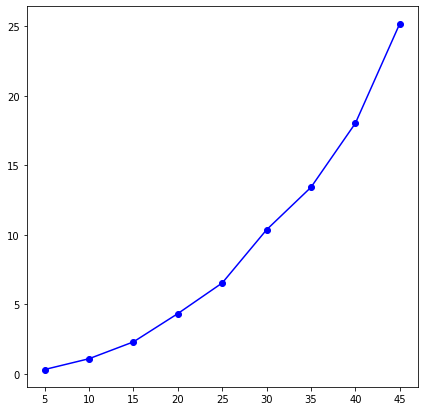

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=[7,7])
plt.plot(benchmark.loc["LS"], "bo-")
plt.show()
benchmark.to_csv("../Dati/altro/benchmark.csv", sep=";", encoding = "ISO-8859-1")

In [13]:
#TIME LOCAL SEARCH
week= ['lunedi', 'martedi', 'mercoledi', 'giovedi', 'venerdi']
path1 = "../Dati/turni_f/fine_optimized_start/foss_greedy1.csv"
path2 = "../Dati/turni_f/optimized_start/oss_ls1.csv"
results = pd.read_csv("../Dati/altro/computational_times_FOSS.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)

to_path1 = "../Dati/turni_f/fine_optimized_start/foss_ls1.csv"
to_path2 = "../Dati/turni_f/fine_optimized_start/foss_ls2.csv"

fur1 = pd.read_csv(path1, delimiter=";", encoding = "ISO-8859-1")
fur2 = pd.read_csv(path2, delimiter=";", encoding = "ISO-8859-1")
to_write = pd.DataFrame({})
results = pd.concat([results, pd.Series(index=["LS"])])
for day in week:
    print(day)
    s = fur1[day].dropna()
    sch, cst, t, c = definitive_local_search(s, 1, dft)
    results[day]["LS"]=(t, len(fur1[day].dropna())-2, c)
#     sch.insert(0, 'Cremona, Sesto 39')
#     sch.append('Ostiano, Mazzini, 1')
    to_write = pd.concat([to_write, pd.DataFrame(pd.Series(sch).rename(day))], axis=1)
#to_write.to_csv(to_path1, index=False, sep=";", encoding = "ISO-8859-1")
results

C:\Users\Alberto\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


lunedi


C:\Users\Alberto\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


martedi
mercoledi
giovedi
venerdi


,0,giovedi,lunedi,martedi,mercoledi,venerdi
greedy,NaN,"(0.249, 14)","(0.069, 10)","(0.016, 3)","(0.312, 16)","(0.165, 16)"
LS,NaN,"(1.496, 16, 2)","(0.0, 10, 1)","(0.0, 2, 1)","(0.0, 17, 1)","(1.546, 16, 2)"


In [14]:
results = results[fur1.columns]
results.to_csv("../Dati/altro/computational_times_FOSS.csv", sep=";", encoding = "ISO-8859-1")

In [7]:
week= ['martedi', 'mercoledi', 'giovedi']
data={}
to_write2 = pd.DataFrame(data)
for day in week:
    print(day)
    s = fur2[day].dropna()
    sch, cst = definitive_local_search(s, 2, dft)
#     sch.insert(0, 'Cremona, Sesto 39')
#     sch.append('San Giovanni in Croce, Feudatari, 25 A')
    to_write2 = pd.concat([to_write2, pd.DataFrame(pd.Series(sch).rename(day))], axis=1)
to_write2.to_csv(to_path2, index=False, sep=";", encoding = "ISO-8859-1")

martedi
mercoledi
giovedi


In [9]:
#COMPUTE KM LOCAL SEARCH
to_path1 = "../Dati/turni_f/optimized_start/oss_km_ls1.csv"
to_path2 = "../Dati/turni_f/optimized_start/oss_km_ls2.csv"
week= ['lunedi', 'martedi', 'mercoledi', 'giovedi', 'venerdi']
data={}
to_write = pd.DataFrame(data)
for day in week:
    sch, cst = definitive_local_search(fur1d[day].dropna(), 1, dfd)
    sch.insert(0, 'Cremona, Sesto 39')
    sch.append('Ostiano, Mazzini, 1')
    to_write = pd.concat([to_write, pd.DataFrame(pd.Series(sch).rename(day))], axis=1)
to_write.to_csv(to_path1, index=False, sep=";", encoding = "ISO-8859-1")

In [10]:
week= ['martedi', 'mercoledi', 'giovedi']
data={}
to_write = pd.DataFrame(data)
for day in week:
    sch, cst = definitive_local_search(fur2d[day].dropna(), 2, dfd)
    sch.insert(0, 'Cremona, Sesto 39')
    sch.append('San Giovanni in Croce, Feudatari, 25 A')
    to_write = pd.concat([to_write, pd.DataFrame(pd.Series(sch).rename(day))], axis=1)
to_write.to_csv(to_path2, index=False, sep=";", encoding = "ISO-8859-1")